In [4]:
import os
import pandas as pd
from pandas import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

### **PART 1** : Exploratory Data Analysis

In [5]:
logins = pd.read_json("https://drive.google.com/uc?id=1B1QF765crEc8JOKYdP-18W_RB8bIflt8")

In [6]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [7]:
logins.info() # looks like its just the time depicting the logging in

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
logins.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


Text(0.5, 0, 'Time')

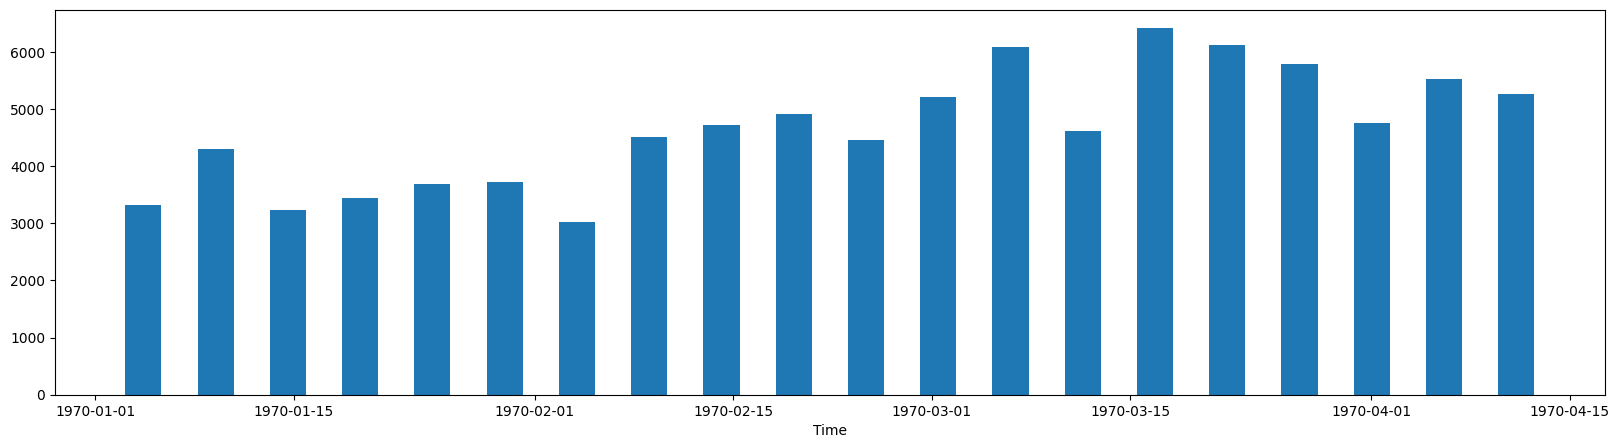

In [9]:
plt.figure(figsize=(20,5))
plt.hist(logins['login_time'], bins = 20, histtype='bar', rwidth=0.5)
plt.xlabel('Time')

In [10]:
# Just to chcek the number of dates

# Extract the date part from the datetime objects
logins['date'] = logins['login_time'].dt.date

# Get the unique dates
unique_dates = logins['date'].unique()

# Print the unique dates
print(len(unique_dates))


103


STEP 1: Aggregate the login counts based on 15 minutes intervals

In [11]:
logins['login_time_rounded'] = logins['login_time'].dt.floor('15min')
login_counts_15min = logins.groupby('login_time_rounded')['login_time'].count()
login_counts_15min


,login_time
login_time_rounded,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [12]:
login_counts_15min.unique()

array([ 2,  6,  9,  7,  1,  4,  8,  3, 16, 13, 14, 15, 10, 18, 12,  5, 17,
       11, 21, 22, 23, 19, 29, 25, 32, 27, 26, 20, 24, 34, 28, 45, 30, 38,
       33, 42, 31, 36, 46, 40, 43, 50, 35, 39, 41, 37, 73, 48, 47, 51, 55,
       53, 44, 52, 60, 54, 63, 64, 56, 59, 66])

In [13]:
# count the number of entries
print(len(login_counts_15min))

9381


**STEP 2:** visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [14]:
login_counts_15min.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 9381 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Series name: login_time
Non-Null Count  Dtype
--------------  -----
9381 non-null   int64
dtypes: int64(1)
memory usage: 146.6 KB


The data starts from 1st January 1970 to 13th April 1970

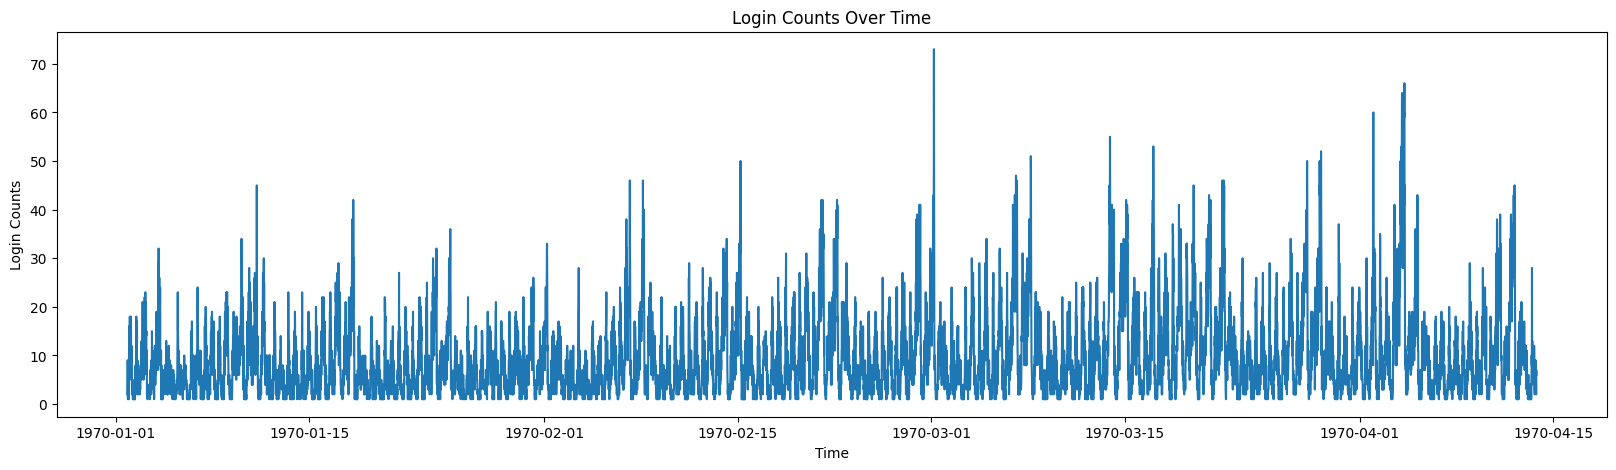

In [15]:
plt.figure(figsize=(20,5))
plt.plot(login_counts_15min)
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts Over Time')
plt.show()

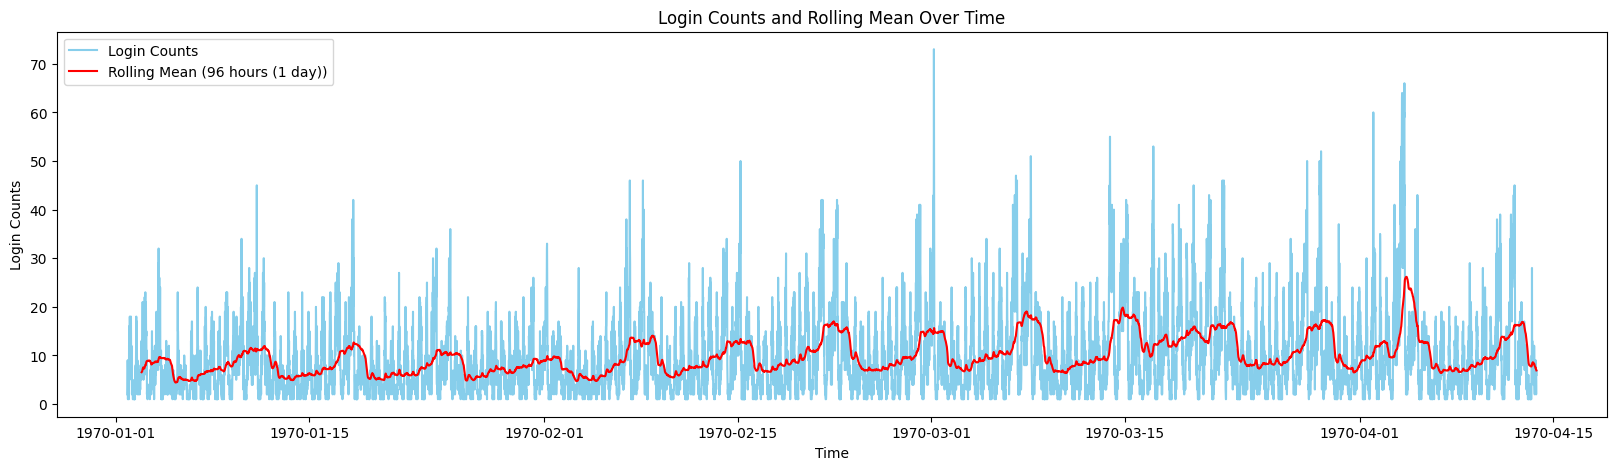

In [16]:
# Lets see the rolling aggregate of the mean

# Calculate the rolling mean with a window size of 96
rolling_mean = login_counts_15min.rolling(window=96).mean()

# window = 96, implies that rolling mean is taken of 96 points and 96 15-minute intervals = 1 day

# Plot the original time series and the rolling mean
plt.figure(figsize=(20,5))
plt.plot(login_counts_15min, label='Login Counts', color = 'skyblue')
plt.plot(rolling_mean, label='Rolling Mean (96 hours (1 day))', color='red')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts and Rolling Mean Over Time')
plt.legend()
plt.show()


**Observations:**

1. **Cyclical Patterns:** The login counts exhibit a clear periodic pattern, suggesting daily fluctuations in activity. Peaks and troughs appear consistently, possibly indicating higher logins during specific hours of the day.

2. **Rolling Mean Smoothing:** The red line (rolling mean) smooths out the short-term fluctuations and highlights the overall trend. This helps in identifying daily trends in login activity without noise.

3. **Spike Patterns:** There are noticeable spikes at regular intervals, which could correspond to peak user activity times (e.g., morning/evening usage spikes).

4. **Long-Term Trend:** While there are fluctuations, the overall trend appears relatively stable without a significant upward or downward shift.

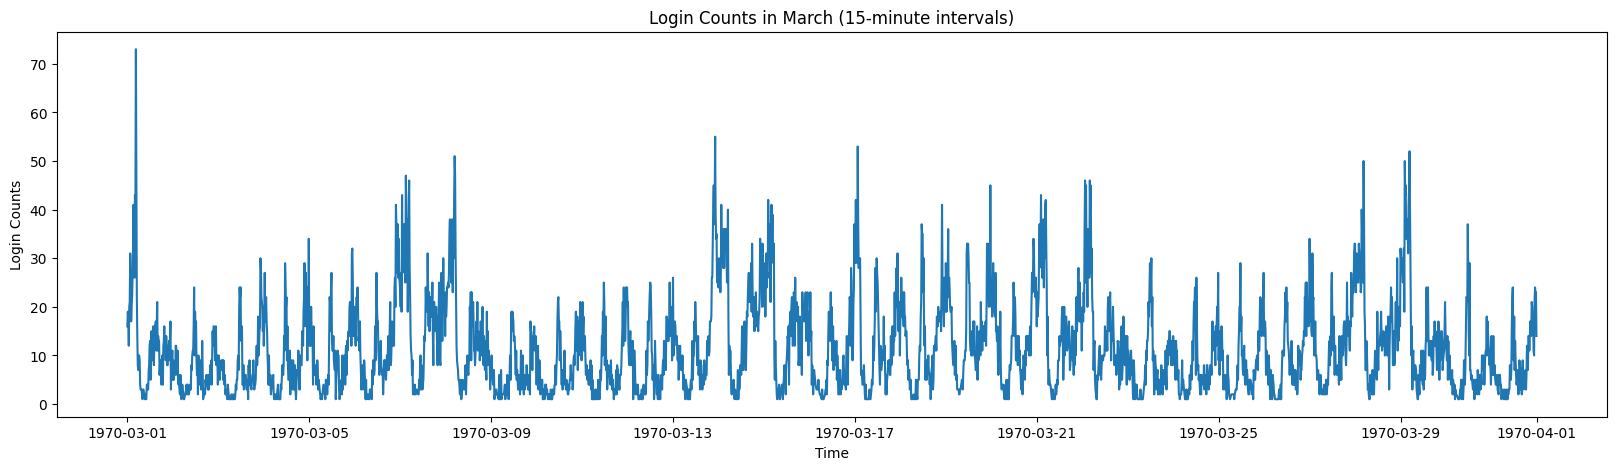

In [17]:
# prompt: plot a single month to check at a granular level, say march

# Filter the data for March
march_data = logins[logins['login_time'].dt.month == 3]

# Group by 15-minute intervals and count logins for March
march_login_counts_15min = march_data.groupby('login_time_rounded')['login_time'].count()

# Plot the login counts for March
plt.figure(figsize=(20, 5))
plt.plot(march_login_counts_15min)
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts in March (15-minute intervals)')
plt.show()


Again the crest and trough like pattern can be seen for the month of march, mimicking the same patterns. Logins are more frequently occuring in certain time windows

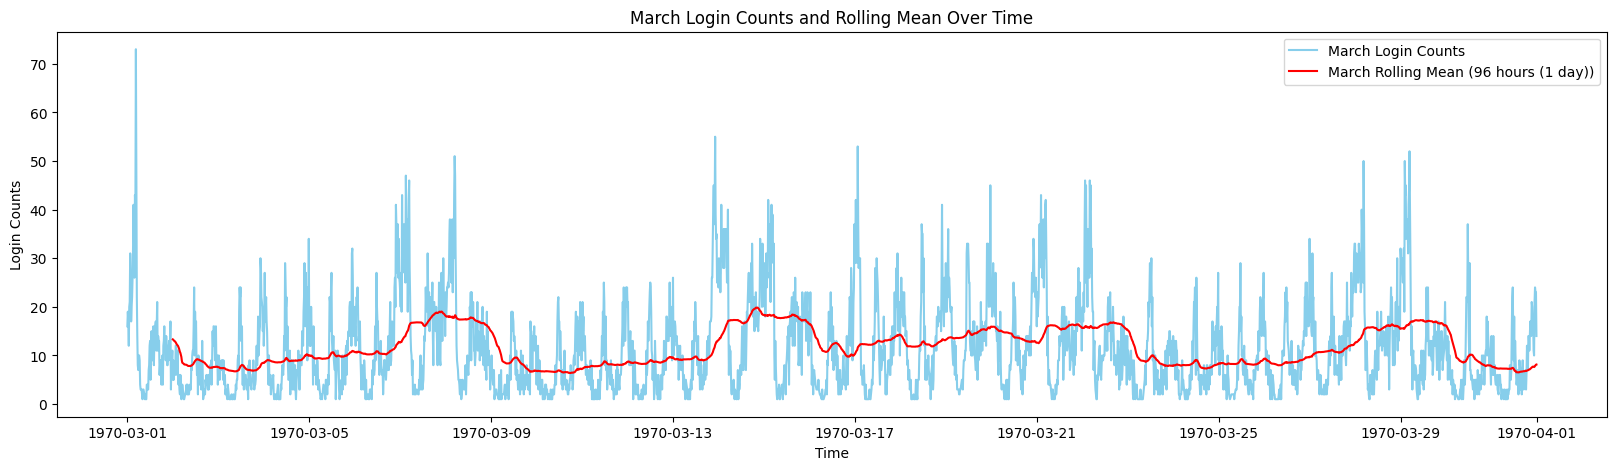

In [18]:
# prompt: do the rolling mean of 96 point windows for the march_login_counts_15min


# Calculate the rolling mean with a window size of 96 for March data
march_rolling_mean = march_login_counts_15min.rolling(window=96).mean()

# Plot the original time series and the rolling mean for March
plt.figure(figsize=(20, 5))
plt.plot(march_login_counts_15min, label='March Login Counts', color='skyblue')
plt.plot(march_rolling_mean, label='March Rolling Mean (96 hours (1 day))', color='red')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('March Login Counts and Rolling Mean Over Time')
plt.legend()
plt.show()


Looks like date 7thor 8th shows a bit of a rise then again 14th and 15th - so like a week end or start of next week ?

In [19]:
# Chcek what day of the week is the 1970-03-07

date_to_check = datetime.date(1970, 3, 7)
day_of_week = date_to_check.weekday()

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print(f"The date 1970-03-07 is a {days[day_of_week]}")


The date 1970-03-07 is a Saturday


In [20]:
date_to_check = datetime.date(1970, 3, 14)
day_of_week = date_to_check.weekday()
print(f"The date 1970-03-07 is a {days[day_of_week]}")


The date 1970-03-07 is a Saturday


I think the peaks are around the weekends. We can now go a bit deeper and take a look at a given week

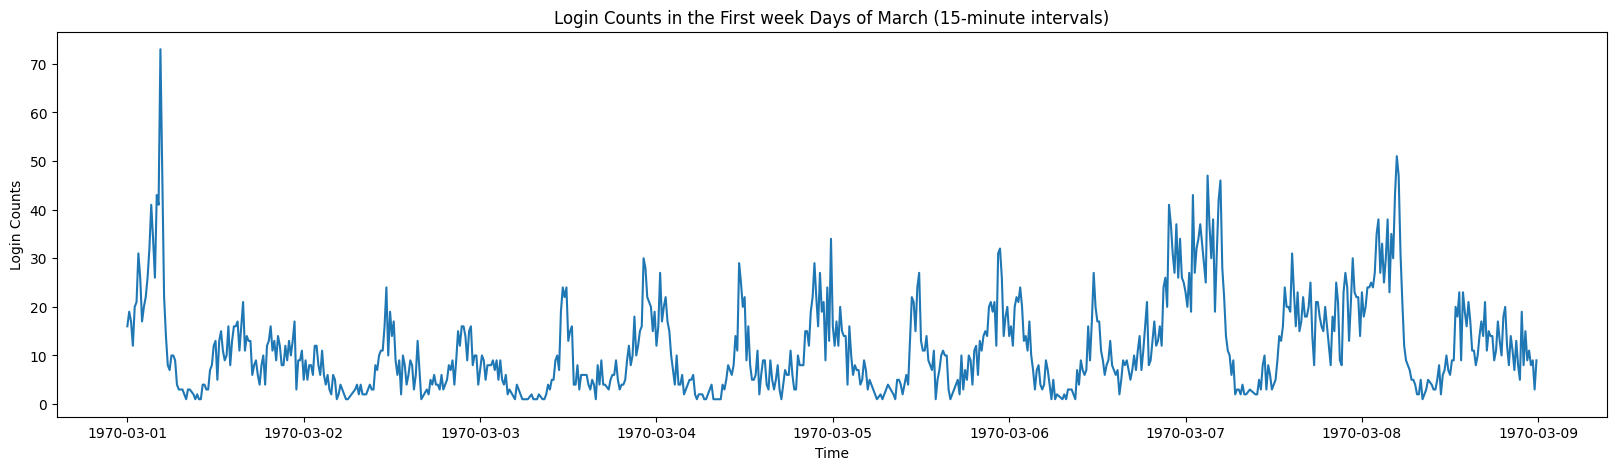

In [21]:
# Filter the data for the first 8 days of March
start_date = datetime.date(1970, 3, 1)
end_date = datetime.date(1970, 3, 8)

march_data = logins[(logins['login_time'].dt.date >= start_date) & (logins['login_time'].dt.date <= end_date)]

# Group by 15-minute intervals and count logins for the first 10 days of March
march_login_counts_15min = march_data.groupby('login_time_rounded')['login_time'].count()

# Plot the login counts for the first 8 days of March
plt.figure(figsize=(20, 5))
plt.plot(march_login_counts_15min)
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts in the First week Days of March (15-minute intervals)')
plt.show()

# The activity seems to be much higher on 7th and 8th of march.

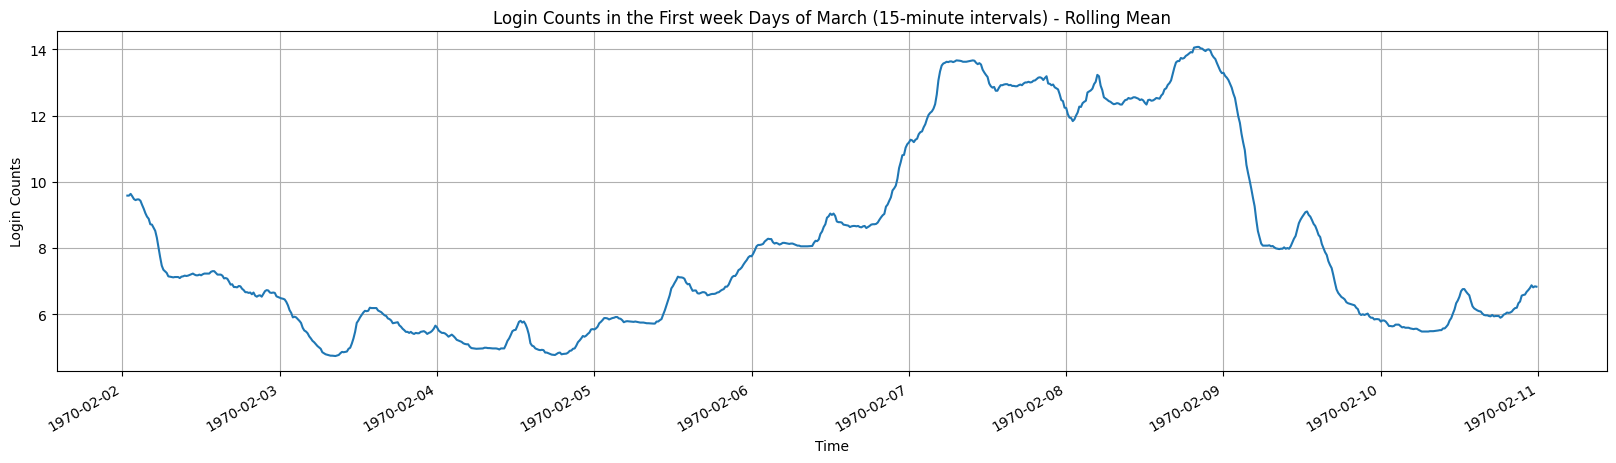

In [22]:
plt.figure(figsize=(20, 5))
login_counts_15min.loc['1970-02-01':'1970-02-10'].rolling(window=96).mean().plot()
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts in the First week Days of March (15-minute intervals) - Rolling Mean')
plt.show()

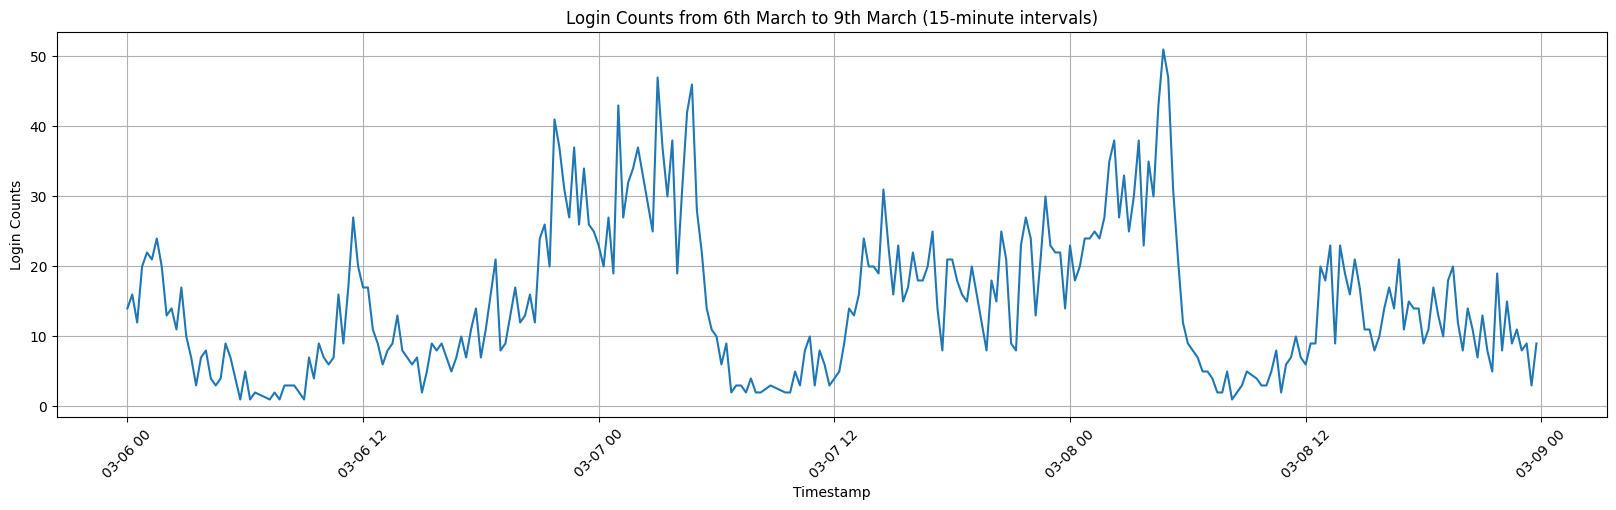

In [23]:
# Filter the data for the specified date range (6th March to 9th March)
start_date = pd.Timestamp('1970-03-06')
end_date = pd.Timestamp('1970-03-09')
filtered_logins = logins[(logins['login_time'] >= start_date) & (logins['login_time'] <= end_date)]

# Group by 15-minute intervals and count logins for the filtered data
filtered_login_counts_15min = filtered_logins.groupby('login_time_rounded')['login_time'].count()

# Plot the login counts for the filtered data with timestamps
plt.figure(figsize=(20, 5))
plt.plot(filtered_login_counts_15min.index, filtered_login_counts_15min.values)
plt.xlabel('Timestamp')
plt.ylabel('Login Counts')
plt.title('Login Counts from 6th March to 9th March (15-minute intervals)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


To conclude i would infer that:
1. Demand is greater over the weekend than the week days
2. The demand is more at noon and midnight ('00'and '12') than any other hours of the day

## **PART 2 and 3**

**Part 2: Experiment and metrics design**

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms:
on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

**Please provide details on:**

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the
observation

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

The ultimate aim is to keep increasing or optimizing the revenue by encouraging drivers to make an inter city commute duirng the peak hours (hence the reimbursement of toll).

1. The best way would be to check how many users remain active on the app after the trial period. Assuming the driving patterns might be dependent on the driver's behavious and nothing to to with the toll incentive that could be very useful.

2. If the surge_pct and avg_surge decreases, we can say the there are more drivers operating at a place at a given time, affecting the revenue per trip. So tracking that might help in that assessment.

We can also keep an eye on the average distance covered by the driver, indicating that more the distance, more trips taken.

Also, keep in mind the seasonality factor of things. If the experiment is conducted in peak season, same results might not be recieved in trough seasons. Since the log data is between 3 months (january to march). Suggesting the implementation of the experiment in some other season would help additionally.

3. As for practical experiment, we can first take a survey of the drivers giving an idea about what number of drivers are already taking the weekend trips and how frequently. This will help us segregate the target numbers even further.

4. Statistical tests that I would think suites:

**Chi-Square Test for Proportions:**
*Null Hypothesis:* No change in the proportion of multi-city drivers. If p-value < 0.05, conclude that toll reimbursement significantly increased cross-city driving.

**Two-Sample t-Test (Pre vs. Post Experiment):** Compare average trips per driver before and after reimbursement. Check if earnings and ratings changed significantly.

Further predictions can be done based on modeling and that will also help us narrow down the feature importance

### **Part 3: Modeling**

In [24]:
data = pd.read_json('https://drive.google.com/uc?id=1zA8ncXGLwzlS2iuVn6loMeCYR-VASUJt')

In [25]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There a number of missing values for avg_rating_of_driver, phone type and avg_rating_by_driver

In [27]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [28]:
# Calculating the missing data percentage
missing_percentage = data.isnull().mean() * 100

# Sort in ascending order
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

missing_percentage_sorted


,0
avg_rating_of_driver,16.244
phone,0.792
avg_rating_by_driver,0.402
city,0.000
signup_date,0.000
trips_in_first_30_days,0.000
last_trip_date,0.000
avg_surge,0.000
surge_pct,0.000
ultimate_black_user,0.000


In [29]:
#  median values for avg_rating_of_driver and avg_rating_by_driver

median_avg_rating_of_driver = data['avg_rating_of_driver'].median()
median_avg_rating_by_driver = data['avg_rating_by_driver'].median()

print(f"Median avg_rating_of_driver: {median_avg_rating_of_driver}")
print(f"Median avg_rating_by_driver: {median_avg_rating_by_driver}")


Median avg_rating_of_driver: 4.9
Median avg_rating_by_driver: 5.0


In [30]:
#percentage of  iphone  and android users

# Calculate the percentage of iPhone and Android users
iphone_users = data[data['phone'] == 'iPhone'].shape[0]
android_users = data[data['phone'] == 'Android'].shape[0]
total_users = data.shape[0]

iphone_percentage = (iphone_users / total_users) * 100
android_percentage = (android_users / total_users) * 100

print(f"Percentage of iPhone users: {iphone_percentage:.2f}%")
print(f"Percentage of Android users: {android_percentage:.2f}%")


Percentage of iPhone users: 69.16%
Percentage of Android users: 30.04%


Based on the analysis above, I would drop the rows with missing phone type, as that is less than 1% of missing values. For the average ratings columns, replace the missing values by the mean values

In [31]:
# prompt: drop the rows with missing phone column values. And replace the missing values for 'avg_rating_of_driver' and 'avg_rating_by_driver' with their mean values using df[col].method(value, inplace=True)

# Drop rows with missing 'phone' values
data.dropna(subset=['phone'], inplace=True)

# Replace missing 'avg_rating_of_driver' and 'avg_rating_by_driver' with their mean
data.fillna({
    'avg_rating_of_driver': data['avg_rating_of_driver'].mean(),
    'avg_rating_by_driver': data['avg_rating_by_driver'].mean()
}, inplace=True)


In [32]:
data.info() #now there are no missing values, makes it fit for modeling

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


<Axes: >

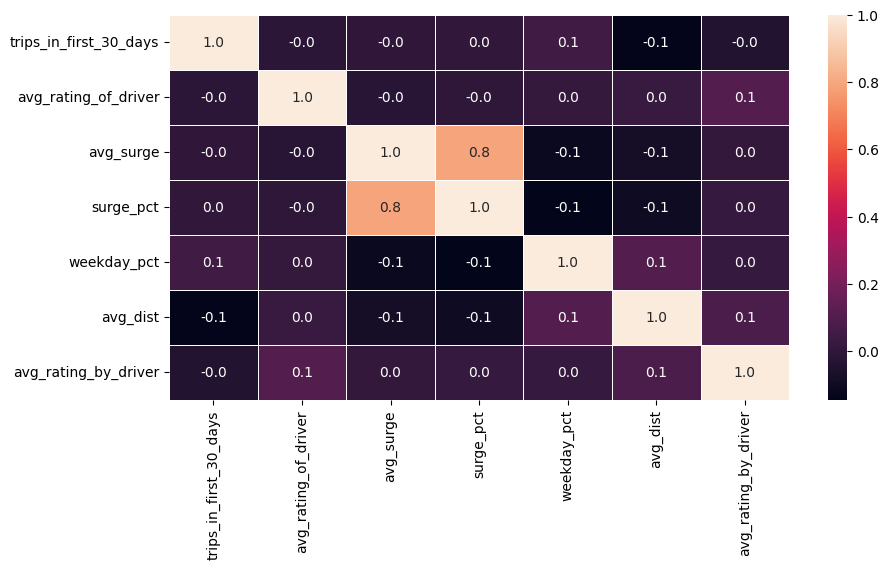

In [33]:
f,ax = plt.subplots(figsize=(10, 5))
numeric_data = data.select_dtypes(include=np.number)
sns.heatmap(numeric_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Average surge and surge percentage has high correlation but that is expected. This is not good for modeling. However many models like XGBoost, random forest are good with high correlations. So i guess we can keep it

In [34]:
# Check if the driver is still active after 30 days of trial perid
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
current_date = data['last_trip_date'].max()
data['active'] = data['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [35]:
# Percentage of active drivers
active_drivers = data['active'].sum()
total_drivers = len(data)
percentage_active = (active_drivers / total_drivers) * 100
percentage_active

np.float64(37.640109668575114)

**Modeling:**
Building a predictive model to predict if the user will stay active on the app for more than first few months

In [36]:
# Feature engineering

In [37]:
# drop features related to target variable created before and not useful to the model (sign_up date)
data.drop('last_trip_date', axis=1, inplace=True)
data.drop('signup_date', axis=1, inplace=True)

In [38]:
data.head(1)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,4.7,1.1,iPhone,15.4,True,46.2,3.67,5.0,1


In [39]:
# seperate the target from the rest of the dataset

features = data.drop('active', axis=1)
y = data['active']


In [40]:
# split the features into two dataframes, one with categorical and other numerical columns
data_numeric = features.select_dtypes(include=['number'])
data_numeric.head(3)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.7,1.1,15.4,46.2,3.67,5.0
1,0,5.0,1.0,0.0,50.0,8.26,5.0
2,3,4.3,1.0,0.0,100.0,0.77,5.0


In [41]:
# Scaling the numeric data

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns, index=data_numeric.index)
data_scaled.head(3)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,0.454159,0.174326,0.112318,0.326417,-0.395941,-0.373113,0.497829
1,-0.600342,0.705091,-0.336789,-0.444014,-0.293477,0.436461,0.497829
2,0.190534,-0.533361,-0.336789,-0.444014,1.054746,-0.884608,0.497829


In [42]:
# The categorical column
data_categorical = data.select_dtypes(include=['object', 'bool'])
data_categorical.head(5)

,city,phone,ultimate_black_user
0,King's Landing,iPhone,True
1,Astapor,Android,False
2,Astapor,iPhone,False
3,King's Landing,iPhone,True
4,Winterfell,Android,False


In [43]:
# Create dummy variables for the 'region' column
data_dummies = pd.get_dummies(data_categorical, drop_first=True).astype(int)
data_dummies.head(3)

,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,1,1,0,1
1,0,0,0,0
2,0,0,0,1


In [44]:
data_final = pd.concat([data_scaled, data_dummies], axis=1)
data_final.head(3)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,0.454159,0.174326,0.112318,0.326417,-0.395941,-0.373113,0.497829,1,1,0,1
1,-0.600342,0.705091,-0.336789,-0.444014,-0.293477,0.436461,0.497829,0,0,0,0
2,0.190534,-0.533361,-0.336789,-0.444014,1.054746,-0.884608,0.497829,0,0,0,1


TRAIN-TEST SPLIT

In [45]:
X = data_final
y = data['active']

In [46]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")


Training set size: 39683 rows
Testing set size: 9921 rows


In [47]:
# Modeling using logistic regression, XGBoost, Random Forest.

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_param_grid = {'C': [0.1, 1, 10]}
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=5)
lr_grid.fit(X_train, y_train)
lr_best_model = lr_grid.best_estimator_
lr_y_pred = lr_best_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier()
xgb_param_grid = {'n_estimators': [50, 100, 200],
                  'learning_rate': [0.01, 0.1, 0.2],
                  'max_depth': [3, 5, 7]}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5)
xgb_grid.fit(X_train, y_train)
xgb_best_model = xgb_grid.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier()
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 5, 10]}
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)


def evaluate_model(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred)
  return accuracy, precision, recall, f1, roc_auc


# Evaluate models
lr_metrics = evaluate_model(y_test, lr_y_pred)
xgb_metrics = evaluate_model(y_test, xgb_y_pred)
rf_metrics = evaluate_model(y_test, rf_y_pred)


In [51]:
#Create a dataframe comparing the performance metrices

model_performance = {
    'Model': ['Logistic Regression', 'XGBoost', 'Random Forest'],
    'Accuracy': [lr_metrics[0], xgb_metrics[0], rf_metrics[0]],
    'Precision': [lr_metrics[1], xgb_metrics[1], rf_metrics[1]],
    'Recall': [lr_metrics[2], xgb_metrics[2], rf_metrics[2]],
    'F1-Score': [lr_metrics[3], xgb_metrics[3], rf_metrics[3]],
    'ROC AUC': [lr_metrics[4], xgb_metrics[4], rf_metrics[4]]
}

# Create a pandas DataFrame from the dictionary
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame
performance_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.713839,0.657725,0.494222,0.564370,0.669934
1,XGBoost,0.791553,0.746349,0.672937,0.707744,0.767840
2,Random Forest,0.781474,0.734238,0.654125,0.691870,0.756014


**CONCLUSION:**

**Based on the model performance metrics, XGBoost is the best-performing model among the three.** It achieves the highest accuracy (79.16%), precision (74.63%), recall (67.29%), F1-score (70.77%), and ROC AUC (76.78%), making it the most balanced model for predicting whether a driver will remain active after the trial period.

**Logistic Regression** has the lowest performance across all metrics, indicating that a simple linear model may not capture the complexities of the data well.

Random Forest performs slightly worse than XGBoost but is still significantly better than Logistic Regression. It may be a good alternative if interpretability is a key concern.

Since XGBoost outperforms the others, it is recommended as the final model for deployment. Further improvements could be achieved through hyperparameter tuning, feature selection.

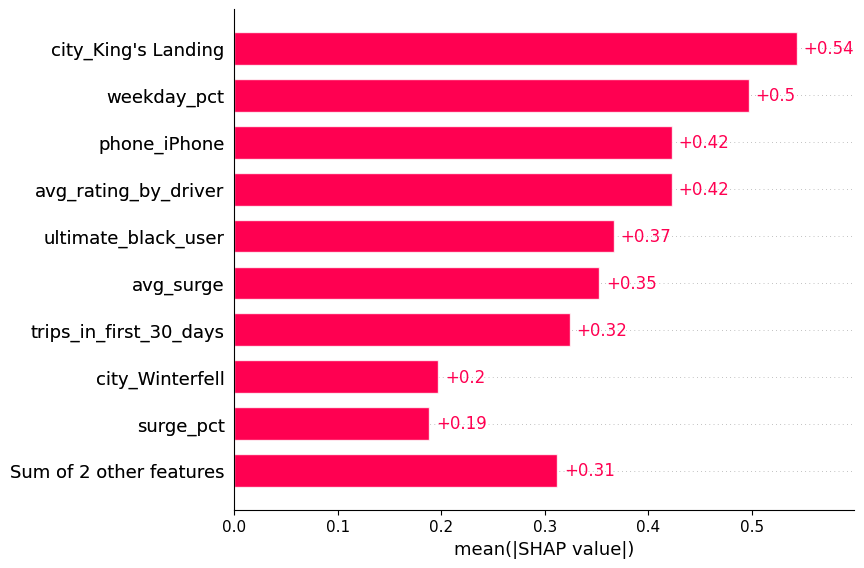

In [54]:
# Set up feature importance bar chart using shap analysis
import shap

# Assuming xgb_best_model is your trained XGBoost model
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

# Feature importance bar chart
shap.plots.bar(shap_values)



**FINAL RECOMMENDATION:**

The most influential factors in predicting driver retention are location, trip patterns, phone type, driver ratings, and early engagement. These insights can help businesses optimize driver retention strategies by targeting key behaviors and regional trends